In [13]:
from ipywidgets import IntProgress
from IPython.display import display,HTML,clear_output
import random
import time
import math
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from uits3_krakow22.src.Event import Event
from uits3_krakow22.src.Cluster import Cluster
from uits3_krakow22.src.Track import Track
from uits3_krakow22.src.Vertex import Vertex
from uits3_krakow22.src.Utils import *
from skspatial.plotting import plot_3d
from skspatial.objects import Points, Cylinder, Plane
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf


display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>table {float:left;}</style>"))

## Simulation
#### Define the target

In [2]:
class Fiber:
    def __init__(self,center=[0,0,0],radius=1,height=10):
        self.center = center
        self.radius = radius
        self.height = height
    
    def getRandomPoint(self):
        R = random.random()*self.radius
        height = (random.random()-0.5)*self.height
        theta = random.random()*2*math.pi
        coordinate = [self.center[0]+R*math.cos(theta),self.center[1]+height,self.center[2]+R*math.sin(theta)]
        return coordinate
    
dist = 0.5
origin = [[0,0,0]]
row1 = [[0,0,-2*dist*math.sqrt(3)]]
row2 = [[-dist*0.5,0,-dist*(3*math.sqrt(3)/2)],[dist*0.5,0,-dist*(3*math.sqrt(3)/2)]]
row3 = [[-dist,0,-dist*math.sqrt(3)],[0,0,-dist*math.sqrt(3)],[dist,0,-dist*math.sqrt(3)]]
row4 = [[-dist*1.5,0,-dist*math.sqrt(3)/2],[-dist*0.5,0,-dist*math.sqrt(3)/2],[dist*0.5,0,-dist*math.sqrt(3)/2],[dist*1.5,0,-dist*math.sqrt(3)/2]]
centers = origin + row1 + row2 + row3 + row4

for center in centers:
    center[2] = center[2]-16.83
print(centers)

fibers = [Fiber(center=center,height=6,radius=0.075) for center in centers]

[[0, 0, -16.83], [0, 0, -18.562050807568877], [-0.25, 0, -18.129038105676656], [0.25, 0, -18.129038105676656], [-0.5, 0, -17.696025403784436], [0, 0, -17.696025403784436], [0.5, 0, -17.696025403784436], [-0.75, 0, -17.26301270189222], [-0.25, 0, -17.26301270189222], [0.25, 0, -17.26301270189222], [0.75, 0, -17.26301270189222]]


#### Create tracks and calculate clusters

In [37]:
def simulateClusters(reps,displacement=None,returnClusters=False):
    if not displacement: displacement = {"ALPIDE_0" : [0,0],"ALPIDE_1" : [0,0],"ALPIDE_2" : [0,0],"ALPIDE_3" : [0,0],"ALPIDE_4" : [0,0]}
    
    localPositions = []
    
    openingAngle = (87.08/360)*2*math.pi
    
    clusters=[]
    # detector geometry
    ALPIDE_0 = Cylinder([0,0,12.5-7.5], [0,0,15], 30)
    ALPIDE_1 = Cylinder([0,0,6.25-7.5], [0,0,15], 24)
    ALPIDE_2 = Cylinder([0,0,0-7.5], [0,0,15], 18)
    ALPIDE_3 = Cylinder([0,0,12.5-7.5], [0,0,15], 30)
    ALPIDE_4 = Cylinder([0,0,0-7.5], [0,0,15], 18)
    alpidesLeft = [ALPIDE_3,ALPIDE_4]
    alpidesRight = [ALPIDE_0,ALPIDE_1,ALPIDE_2]
    
    while len(localPositions) < reps:
        localTmp=[]
        localClusters=[]
        fiber = random.choice(fibers)
        phi = math.pi*(0.5+(random.random()-0.5)*0.2)#*0.265258238
        theta = math.pi/2-openingAngle/2
        shift = (random.random()-0.5)*0.1
        origin = fiber.getRandomPoint()
       
        #calculate right arm clusters
        trackRight = Track(point=origin,vector=[-math.sin(phi)*math.cos(-theta+shift), -math.cos(phi), -math.sin(phi)*math.sin(-theta+shift)])
        for alpide in alpidesRight:
            if alpide is ALPIDE_0: detector = "ALPIDE_0"
            elif alpide is ALPIDE_1: detector = "ALPIDE_1"
            elif alpide is ALPIDE_2: detector = "ALPIDE_2"
            intersection = alpide.intersect_line(trackRight.line)
            cluster = Cluster()
            cluster.setPositionGlobal(intersection[1])
            cluster.detector = detector
            cluster.alignLocal(displacement.get(detector))
            if abs(cluster.localPos[0])<10 and abs(cluster.localPos[1])<5:
                localTmp.extend(cluster.localPos[0:2])
                if returnClusters: localClusters.append(cluster)
        
        #calculate left arm clusters
        trackLeft = Track(point= origin,vector=[math.sin(phi)*math.cos(theta+shift), math.cos(phi), math.sin(phi)*math.sin(theta+shift)])
        for alpide in alpidesLeft:
            if alpide is ALPIDE_3: detector = "ALPIDE_3"
            elif alpide is ALPIDE_4: detector = "ALPIDE_4"
            intersection = alpide.intersect_line(trackLeft.line)
            cluster = Cluster()
            cluster.setPositionGlobal(intersection[1])
            cluster.detector = detector
            cluster.alignLocal(displacement.get(detector))
            if abs(cluster.localPos[0])<10 and abs(cluster.localPos[1])<5:
                localTmp.extend(cluster.localPos[0:2])
                if returnClusters: localClusters.append(cluster)
        
        if len(localTmp) == 10:
            localPositions.append(localTmp)
            if returnClusters: clusters.append(localClusters)
    
    if returnClusters: return clusters
    else: return localPositions

def dispMap2Array(displacement):
    output=[]
    for key in ["ALPIDE_0","ALPIDE_1","ALPIDE_2","ALPIDE_3","ALPIDE_4"]:
        output.extend(displacement[key])
    return output

def dispArray2Map(displacement):
    disp = np.reshape(np.array(displacement), (5,-1))
    output={}
    detectors = ["ALPIDE_0","ALPIDE_1","ALPIDE_2","ALPIDE_3","ALPIDE_4"]
    for det,vals in enumerate(disp):
        output[detectors[det]] = vals.tolist()
    return output

In [4]:
events = simulateClusters(1000, returnClusters=True)
%jsroot on
hClusters= ROOT.TH3F("ClustersXYZ","ClustersXYZ",100,-40,40, 100,-40,40, 100,-40,-40)
for event in events:
    for cluster in event:
        #if abs(cluster.localPos[0])<5 and abs(cluster.localPos[1])<2:
        hClusters.Fill(cluster.globalPos[0],cluster.globalPos[1],cluster.globalPos[2])
    
canvas = ROOT.TCanvas()
hClusters.Draw("BOX3")
canvas.Draw("")

### Generate simulated data

In [5]:
def split_train_val_indices(data_size, val_ratio=0.2, shuffle=True, random_seed=None):
    """
    Randomly splits the indices into training and validation sets.

    Args:
        data_size (int): Total number of data points.
        val_ratio (float): Ratio of validation data points (default: 0.2).
        shuffle (bool): Whether to shuffle the indices (default: True).
        random_seed (int): Random seed for reproducibility (default: None).

    Returns:
        train_indices (ndarray): Array of indices for the training set.
        val_indices (ndarray): Array of indices for the validation set.
    """
    # Set the random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)

    # Create an array of indices
    indices = np.arange(data_size)

    # Shuffle the indices if required
    if shuffle:
        np.random.shuffle(indices)

    # Calculate the number of validation samples
    val_size = int(val_ratio * data_size)

    # Split the indices into training and validation sets
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]

    return train_indices, val_indices

In [55]:
def generateData(nDisplacements=1000,dispRange=[-0.5,0.5],nReps=1000,alpides2move=[True,True,True,True,True]):
    data = []
    misal = []
    alpides = ["ALPIDE_0","ALPIDE_1","ALPIDE_2","ALPIDE_3","ALPIDE_4"]
    for i in range(nDisplacements):
        #print("Displacement #",i)
        displacement = {}
        for det,alpide in enumerate(alpides):
            if alpides2move[det]:
                displacement[alpide] = [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])]
            else:
                displacement[alpide] = [0,0]
                
        data.extend(simulateClusters(nReps,displacement))
        misal.extend([dispMap2Array(displacement)]*nReps)
    input_data = np.array(data)
    input_data = np.reshape(input_data, (-1, 10))
    misalignments  = np.array(misal)
    return input_data,misalignments

## Machine learning with tensorflow

In [7]:
def createNetwork(units=64,nLayers=1):
    # Create the sequential model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=units, activation='relu', input_shape=(10,)))
    
    for i in range(nLayers-1):
        model.add(tf.keras.layers.Dense(units=units, activation='relu'))

    # Add the output layer with the desired number of units (30 in your case)
    model.add(tf.keras.layers.Dense(units=10))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    return model
    
def trainNetwork(model,input_data,misalignments,nEpochs=10,batch=32):
    data_size = len(input_data)

    # Normalize the input data
    #input_data = (input_data - np.mean(input_data, axis=0)) / np.std(input_data, axis=0)

    # Split the indices into training and validation sets
    train_indices, val_indices = split_train_val_indices(data_size, val_ratio=0.2, shuffle=True, random_seed=42)
    train_input = input_data[train_indices]
    train_misalignments = misalignments[train_indices]
    val_input = input_data[val_indices]
    val_misalignments = misalignments[val_indices]

    # Reshape the input data to have at least two dimensions
    train_input = np.reshape(train_input, (-1, 10))
    val_input = np.reshape(val_input, (-1, 10))

    # Train the model
    num_epochs = nEpochs
    batch_size = batch
    model.fit(x=train_input, y=train_misalignments, epochs=num_epochs, batch_size=batch_size, validation_data=(val_input, val_misalignments))
    return model

In [8]:
def evalModel(model,displacements,nReps=1000):
    dists=np.array([])
    for displacement in displacements:
        data = simulateClusters(nReps,displacement)
        test_data = np.reshape(np.array(data), (-1, 10))
        predictions = model.predict(test_data)
        predicted_disp = np.mean(predictions,axis=0)
        dist = np.linalg.norm(dispMap2Array(displacement)-predicted_disp)
        dists = np.append(dists,dist)
    return dists

## Running the stuff

In [31]:
%%time
input_data, misalignments = generateData(nDisplacements=100,dispRange=[-0.5,0.5],nReps=1000)

Displacement # 0
Displacement # 1
Displacement # 2
Displacement # 3
Displacement # 4
Displacement # 5
Displacement # 6
Displacement # 7
Displacement # 8
Displacement # 9
Displacement # 10
Displacement # 11
Displacement # 12
Displacement # 13
Displacement # 14
Displacement # 15
Displacement # 16
Displacement # 17
Displacement # 18
Displacement # 19
Displacement # 20
Displacement # 21
Displacement # 22
Displacement # 23
Displacement # 24
Displacement # 25
Displacement # 26
Displacement # 27
Displacement # 28
Displacement # 29
Displacement # 30
Displacement # 31
Displacement # 32
Displacement # 33
Displacement # 34
Displacement # 35
Displacement # 36
Displacement # 37
Displacement # 38
Displacement # 39
Displacement # 40
Displacement # 41
Displacement # 42
Displacement # 43
Displacement # 44
Displacement # 45
Displacement # 46
Displacement # 47
Displacement # 48
Displacement # 49
Displacement # 50
Displacement # 51
Displacement # 52
Displacement # 53
Displacement # 54
Displacement # 55
Di

In [34]:
%%time
model = createNetwork(units=50,nLayers=2)
model = trainNetwork(model,input_data,misalignments,nEpochs=10,batch=32)

Epoch 1/10
2500/2500 [==============================] - 2s 824us/step - loss: 0.0219 - val_loss: 0.0028
Epoch 2/10
2500/2500 [==============================] - 2s 814us/step - loss: 0.0021 - val_loss: 0.0014
Epoch 3/10
2500/2500 [==============================] - 2s 814us/step - loss: 0.0011 - val_loss: 7.0427e-04
Epoch 4/10
2500/2500 [==============================] - 2s 830us/step - loss: 7.3388e-04 - val_loss: 8.4054e-04
Epoch 5/10
2500/2500 [==============================] - 2s 806us/step - loss: 5.1599e-04 - val_loss: 9.3934e-04
Epoch 6/10
2500/2500 [==============================] - 2s 798us/step - loss: 4.1713e-04 - val_loss: 3.9366e-04
Epoch 7/10
2500/2500 [==============================] - 2s 831us/step - loss: 3.2362e-04 - val_loss: 4.8169e-04
Epoch 8/10
2500/2500 [==============================] - 2s 790us/step - loss: 2.7718e-04 - val_loss: 2.2210e-04
Epoch 9/10
2500/2500 [==============================] - 2s 810us/step - loss: 2.2659e-04 - val_loss: 1.4277e-04
Epoch 10/10


In [35]:
%%time
dists = np.array([])
disps2test=[]
nPoints2test = 10
dispRange = [-0.5,0.5]
for i in range(nPoints2test):
    displacement = {
        "ALPIDE_0" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
        "ALPIDE_1" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
        "ALPIDE_2" : [0,0],
        "ALPIDE_3" : [0,0],
        "ALPIDE_4" : [0,0]
    }
    disps2test.append(displacement)
dists = evalModel(model,disps2test)
meanDist = np.mean(dists)
medianDist = np.median(dists)
stdDist = np.std(dists)
print(f"Tested {nPoints2test} points and got Mean: {meanDist:.3f} - Median: {medianDist:.3f} - StdDev: {stdDist:.3f}")

32/32 [==============================] - 0s 677us/step
Tested 10 points and got Mean: 0.011 - Median: 0.011 - StdDev: 0.003
CPU times: user 6.14 s, sys: 69.4 ms, total: 6.2 s
Wall time: 6.11 s


## All of it in one for loop

In [51]:
%%time
# Create testing data
disps2test=[]
nPoints2test = 10
dispRange = [-0.5,0.5]
for i in range(nPoints2test):
    displacement = {
        "ALPIDE_0" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
        "ALPIDE_1" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
        "ALPIDE_2" : [0,0],
        "ALPIDE_3" : [0,0],
        "ALPIDE_4" : [0,0]
    }
    disps2test.append(displacement)

# Main training loop
nDispsPerLoop = 50
nDisps = 500
input_data = np.array([])
misalignments = np.array([])
meanDists = np.array([])
stdDists = np.array([])
medianDists = np.array([])
nRepVals = [i for i in range(100,1050,100)]
for iteration,nReps in enumerate(nRepVals):
    # Generate data for training
    print("Round:",iteration,"-> Generating displacements #",nDisps, "- nReps:",nReps)
    new_data, new_misalignments = generateData(nDisplacements=nDispsPerLoop,dispRange=[-0.5,0.5],nReps=nReps)
    input_data = np.reshape(np.append(input_data,new_data), (-1, 10))
    misalignments = np.reshape(np.append(misalignments,new_misalignments), (-1, 10))
    # Create model
    model = createNetwork(units=50,nLayers=2)
    # Train network with new data
    model = trainNetwork(model,input_data,misalignments,nEpochs=10,batch=32)
    # Evaluate performance of model
    dists = np.array([])
    dists = evalModel(model,disps2test)
    meanDist = np.mean(dists)
    medianDist = np.median(dists)
    stdDist = np.std(dists)
    meanDists = np.append(meanDists,meanDist)
    stdDists = np.append(stdDists,stdDist)
    medianDists = np.append(medianDists,medianDist)
    print(f"Tested {nPoints2test} points and got Mean: {meanDist:.3f} - Median: {medianDist:.3f} - StdDev: {stdDist:.3f}")

Round: 0 -> Generating displacements # 500 - nReps: 100
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.1891 - val_loss: 0.0451
Epoch 2/10
125/125 [==============================] - 0s 947us/step - loss: 0.0389 - val_loss: 0.0358
Epoch 3/10
125/125 [==============================] - 0s 984us/step - loss: 0.0331 - val_loss: 0.0322
Epoch 4/10
125/125 [==============================] - 0s 980us/step - loss: 0.0292 - val_loss: 0.0279
Epoch 5/10
125/125 [==============================] - 0s 945us/step - loss: 0.0255 - val_loss: 0.0239
Epoch 6/10
125/125 [==============================] - 0s 958us/step - loss: 0.0217 - val_loss: 0.0204
Epoch 7/10
125/125 [==============================] - 0s 958us/step - loss: 0.0181 - val_loss: 0.0172
Epoch 8/10
125/125 [==============================] - 0s 980us/step - loss: 0.0151 - val_loss: 0.0140
Epoch 9/10
125/125 [==============================] - 0s 954us/step - loss: 0.0126 - val_loss: 0.0117
Epoch 10/10
32/32 [=========

6875/6875 [==============================] - 6s 823us/step - loss: 7.5688e-05 - val_loss: 5.4827e-05
Epoch 6/10
6875/6875 [==============================] - 6s 823us/step - loss: 6.1397e-05 - val_loss: 6.4265e-05
Epoch 7/10
6875/6875 [==============================] - 6s 827us/step - loss: 5.0653e-05 - val_loss: 4.2021e-05
Epoch 8/10
6875/6875 [==============================] - 6s 831us/step - loss: 4.7023e-05 - val_loss: 5.0726e-05
Epoch 9/10
6875/6875 [==============================] - 6s 920us/step - loss: 4.1002e-05 - val_loss: 3.2711e-05
Epoch 10/10
32/32 [==============================] - 0s 617us/step
Tested 10 points and got Mean: 0.007 - Median: 0.007 - StdDev: 0.001
CPU times: user 10min 59s, sys: 19 s, total: 11min 18s
Wall time: 9min 48s


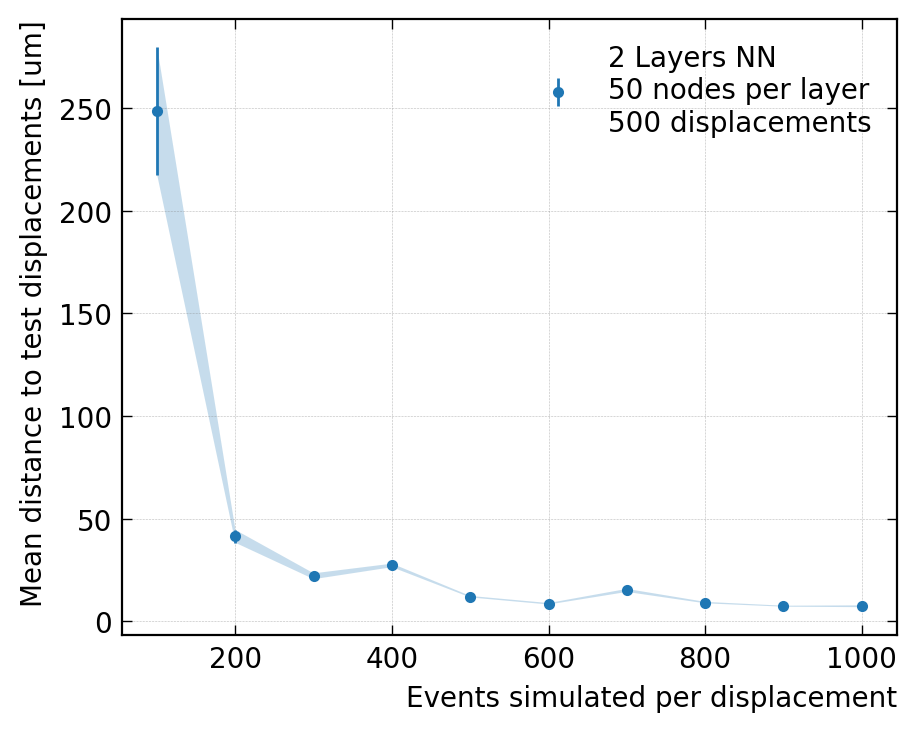

In [53]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(5, 4), dpi=200)
#xVals = np.array([(i+1)*nDispsPerLoop for i in range(int(nDisps/nDispsPerLoop))])
#xVals = np.array([(i+1)*nDispsPerLoop for i in range(len(meanDists))])
xVals = nRepVals
ax = fig.add_subplot(111)
ax.tick_params(axis='both',which='both', direction='in',right=True,top=True, width=0.5)
plt.grid(color='gray', linestyle=':', linewidth=0.2)
ax.set_xlabel("Events simulated per displacement", horizontalalignment='right',x=1)
ax.set_ylabel("Mean distance to test displacements [um]", horizontalalignment='right',y=1)
#ax.set_xlim(0,nDisps*1.1)
#ax.set_ylim(0,0.02)
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1000))
ax.yaxis.set_major_formatter(ticks)
ax.errorbar(xVals,meanDists,stdDists/math.sqrt(nPoints2test),None,'.', label="2 Layers NN\n50 nodes per layer\n500 displacements", linewidth=1)
ax.fill_between(xVals,meanDists-stdDists/math.sqrt(nPoints2test),meanDists+stdDists/math.sqrt(nPoints2test),alpha=0.25,linewidth=1)
l = ax.legend(loc='best', frameon=False)

## All ALPIDEs

In [8]:
def generateDataAll(nDisplacements=1000,dispRange=[-0.5,0.5],nReps=1000):
    data = []
    misal = []
    for i in range(nDisplacements):
        #print("Displacement #",i)
        displacement = {
            "ALPIDE_0" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
            "ALPIDE_1" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
            "ALPIDE_2" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
            "ALPIDE_3" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
            "ALPIDE_4" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])]
        }
        data.extend(simulateClusters(nReps,displacement))
        misal.extend([dispMap2Array(displacement)]*nReps)
    input_data = np.array(data)
    input_data = np.reshape(input_data, (-1, 10))
    misalignments  = np.array(misal)
    return input_data,misalignments

In [9]:
%%time
# Create testing data
disps2test=[]
nPoints2test = 10
dispRange = [-0.5,0.5]
for i in range(nPoints2test):
    displacement = {
        "ALPIDE_0" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
        "ALPIDE_1" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
        "ALPIDE_2" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
        "ALPIDE_3" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
        "ALPIDE_4" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])]
    }
    disps2test.append(displacement)

# Main training loop
nDispsPerLoop = 50
nDisps = 1000
input_data = np.array([])
misalignments = np.array([])
meanDists = np.array([])
stdDists = np.array([])
medianDists = np.array([])
for iteration in range(int(nDisps/nDispsPerLoop)):
    # Generate data for training
    print("Round:",iteration,"-> Generating displacement #",iteration*nDispsPerLoop)
    new_data, new_misalignments = generateDataAll(nDisplacements=nDispsPerLoop,dispRange=[-0.5,0.5],nReps=1000)
    input_data = np.reshape(np.append(input_data,new_data), (-1, 10))
    misalignments = np.reshape(np.append(misalignments,new_misalignments), (-1, 10))
    # Create model
    model = createNetwork(units=50,nLayers=2)
    # Train network with new data
    model = trainNetwork(model,input_data,misalignments,nEpochs=10,batch=32)
    # Evaluate performance of model
    dists = np.array([])
    dists = evalModel(model,disps2test)
    meanDist = np.mean(dists)
    medianDist = np.median(dists)
    stdDist = np.std(dists)
    meanDists = np.append(meanDists,meanDist)
    stdDists = np.append(stdDists,stdDist)
    medianDists = np.append(medianDists,medianDist)
    print(f"Tested {nPoints2test} points and got Mean: {meanDist:.3f} - Median: {medianDist:.3f} - StdDev: {stdDist:.3f}")

Round: 0 -> Generating displacement # 0
Epoch 1/10
1250/1250 [==============================] - 1s 885us/step - loss: 0.0858 - val_loss: 0.0407
Epoch 2/10
1250/1250 [==============================] - 1s 800us/step - loss: 0.0329 - val_loss: 0.0301
Epoch 3/10
1250/1250 [==============================] - 1s 822us/step - loss: 0.0284 - val_loss: 0.0274
Epoch 4/10
1250/1250 [==============================] - 1s 815us/step - loss: 0.0260 - val_loss: 0.0242
Epoch 5/10
1250/1250 [==============================] - 1s 805us/step - loss: 0.0231 - val_loss: 0.0212
Epoch 6/10
1250/1250 [==============================] - 1s 802us/step - loss: 0.0190 - val_loss: 0.0173
Epoch 7/10
1250/1250 [==============================] - 1s 812us/step - loss: 0.0156 - val_loss: 0.0143
Epoch 8/10
1250/1250 [==============================] - 1s 811us/step - loss: 0.0130 - val_loss: 0.0119
Epoch 9/10
1250/1250 [==============================] - 1s 796us/step - loss: 0.0110 - val_loss: 0.0107
Epoch 10/10
32/32 [=====

Epoch 10/10
32/32 [==============================] - 0s 561us/step
Tested 10 points and got Mean: 0.720 - Median: 0.769 - StdDev: 0.197
Round: 10 -> Generating displacement # 500
Epoch 1/10
13750/13750 [==============================] - 11s 806us/step - loss: 0.0402 - val_loss: 0.0344
Epoch 2/10
13750/13750 [==============================] - 11s 810us/step - loss: 0.0334 - val_loss: 0.0322
Epoch 3/10
13750/13750 [==============================] - 11s 813us/step - loss: 0.0310 - val_loss: 0.0302
Epoch 4/10
13750/13750 [==============================] - 11s 802us/step - loss: 0.0293 - val_loss: 0.0281
Epoch 5/10
13750/13750 [==============================] - 11s 801us/step - loss: 0.0281 - val_loss: 0.0283
Epoch 6/10
13750/13750 [==============================] - 11s 801us/step - loss: 0.0271 - val_loss: 0.0265
Epoch 7/10
13750/13750 [==============================] - 11s 802us/step - loss: 0.0263 - val_loss: 0.0259
Epoch 8/10
13750/13750 [==============================] - 12s 839us/step

Epoch 1/10
25000/25000 [==============================] - 21s 835us/step - loss: 0.0387 - val_loss: 0.0347
Epoch 2/10
25000/25000 [==============================] - 20s 799us/step - loss: 0.0333 - val_loss: 0.0323
Epoch 3/10
25000/25000 [==============================] - 20s 810us/step - loss: 0.0321 - val_loss: 0.0324
Epoch 4/10
25000/25000 [==============================] - 20s 804us/step - loss: 0.0312 - val_loss: 0.0306
Epoch 5/10
25000/25000 [==============================] - 20s 804us/step - loss: 0.0306 - val_loss: 0.0306
Epoch 6/10
25000/25000 [==============================] - 20s 792us/step - loss: 0.0300 - val_loss: 0.0294
Epoch 7/10
25000/25000 [==============================] - 21s 829us/step - loss: 0.0295 - val_loss: 0.0292
Epoch 8/10
25000/25000 [==============================] - 20s 804us/step - loss: 0.0292 - val_loss: 0.0288
Epoch 9/10
25000/25000 [==============================] - 20s 798us/step - loss: 0.0289 - val_loss: 0.0293
Epoch 10/10
32/32 [==================

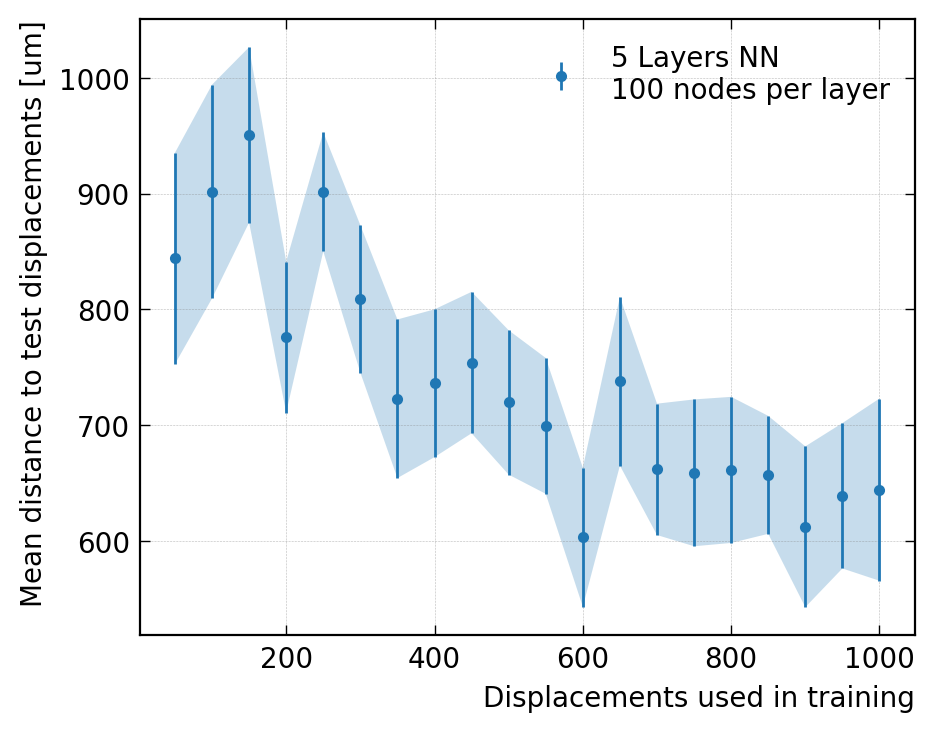

In [20]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(5, 4), dpi=200)
#xVals = np.array([(i+1)*nDispsPerLoop for i in range(int(nDisps/nDispsPerLoop))])
xVals = np.array([(i+1)*nDispsPerLoop for i in range(len(meanDists))])
ax = fig.add_subplot(111)
ax.tick_params(axis='both',which='both', direction='in',right=True,top=True, width=0.5)
plt.grid(color='gray', linestyle=':', linewidth=0.2)
ax.set_xlabel("Displacements used in training", horizontalalignment='right',x=1)
ax.set_ylabel("Mean distance to test displacements [um]", horizontalalignment='right',y=1)
#ax.set_xlim(0,nDisps*1.1)
#ax.set_ylim(0,0.02)
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1000))
ax.yaxis.set_major_formatter(ticks)
ax.errorbar(xVals,meanDists,stdDists/math.sqrt(nPoints2test),None,'.', label="5 Layers NN\n100 nodes per layer", linewidth=1)
ax.fill_between(xVals,meanDists-stdDists/math.sqrt(nPoints2test),meanDists+stdDists/math.sqrt(nPoints2test),alpha=0.25,linewidth=1)
l = ax.legend(loc='best', frameon=False)

In [18]:
xVals/1000

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

## Random stuff

In [171]:
%%time
meanDists = np.array([])
stdDists = np.array([])
xVals = np.array([i for i in range(30,120,10)])
for units in xVals:
    dists = np.array([])
    for rep in range(10):
        model = trainNetwork(input_data,misalignments,units=units)
        disps2test = [{"ALPIDE_0" : [0,0,0],"ALPIDE_1" : [(val-0.5)*2,0,0],"ALPIDE_2" : [0,0,0],"ALPIDE_3" : [0,0,0],"ALPIDE_4" : [0,0,0]} for val in np.random.rand(10)]
        dists = np.append(dists,evalModel(model,disps2test))
    meanDists = np.append(meanDists,np.mean(dists))
    stdDists = np.append(stdDists,np.std(dists))

Epoch 1/10
1250/1250 [==============================] - 2s 879us/step - loss: 0.1650 - val_loss: 0.0171
Epoch 2/10
1250/1250 [==============================] - 1s 790us/step - loss: 0.0087 - val_loss: 0.0032
Epoch 3/10
1250/1250 [==============================] - 1s 784us/step - loss: 0.0016 - val_loss: 7.7458e-04
Epoch 4/10
1250/1250 [==============================] - 1s 803us/step - loss: 4.4717e-04 - val_loss: 3.0067e-04
Epoch 5/10
1250/1250 [==============================] - 1s 803us/step - loss: 2.1471e-04 - val_loss: 1.5855e-04
Epoch 6/10
1250/1250 [==============================] - 1s 807us/step - loss: 1.3730e-04 - val_loss: 1.3166e-04
Epoch 7/10
1250/1250 [==============================] - 1s 792us/step - loss: 1.0980e-04 - val_loss: 9.6091e-05
Epoch 8/10
1250/1250 [==============================] - 1s 806us/step - loss: 8.3853e-05 - val_loss: 1.0753e-04
Epoch 9/10
1250/1250 [==============================] - 1s 807us/step - loss: 7.6089e-05 - val_loss: 7.1578e-05
Epoch 10/10


32/32 [==============================] - 0s 628us/step
Epoch 1/10
1250/1250 [==============================] - 1s 818us/step - loss: 0.2596 - val_loss: 0.0236
Epoch 2/10
1250/1250 [==============================] - 1s 758us/step - loss: 0.0145 - val_loss: 0.0068
Epoch 3/10
1250/1250 [==============================] - 1s 776us/step - loss: 0.0030 - val_loss: 0.0011
Epoch 4/10
1250/1250 [==============================] - 1s 764us/step - loss: 6.7268e-04 - val_loss: 4.2365e-04
Epoch 5/10
1250/1250 [==============================] - 1s 791us/step - loss: 3.0303e-04 - val_loss: 2.1164e-04
Epoch 6/10
1250/1250 [==============================] - 1s 780us/step - loss: 1.7991e-04 - val_loss: 1.7174e-04
Epoch 7/10
1250/1250 [==============================] - 1s 785us/step - loss: 1.2670e-04 - val_loss: 9.2931e-05
Epoch 8/10
1250/1250 [==============================] - 1s 791us/step - loss: 9.9268e-05 - val_loss: 1.1721e-04
Epoch 9/10
1250/1250 [==============================] - 1s 763us/step - l

32/32 [==============================] - 0s 625us/step
Epoch 1/10
1250/1250 [==============================] - 1s 816us/step - loss: 0.0974 - val_loss: 0.0061
Epoch 2/10
1250/1250 [==============================] - 1s 782us/step - loss: 0.0028 - val_loss: 0.0012
Epoch 3/10
1250/1250 [==============================] - 1s 771us/step - loss: 7.0694e-04 - val_loss: 4.6180e-04
Epoch 4/10
1250/1250 [==============================] - 1s 781us/step - loss: 3.2441e-04 - val_loss: 2.3022e-04
Epoch 5/10
1250/1250 [==============================] - 1s 798us/step - loss: 1.8945e-04 - val_loss: 1.3923e-04
Epoch 6/10
1250/1250 [==============================] - 1s 768us/step - loss: 1.2708e-04 - val_loss: 9.9208e-05
Epoch 7/10
1250/1250 [==============================] - 1s 771us/step - loss: 9.6583e-05 - val_loss: 1.2059e-04
Epoch 8/10
1250/1250 [==============================] - 1s 776us/step - loss: 9.6755e-05 - val_loss: 5.1928e-05
Epoch 9/10
1250/1250 [==============================] - 1s 778us/

32/32 [==============================] - 0s 632us/step
Epoch 1/10
1250/1250 [==============================] - 1s 829us/step - loss: 0.1132 - val_loss: 0.0065
Epoch 2/10
1250/1250 [==============================] - 1s 775us/step - loss: 0.0028 - val_loss: 0.0012
Epoch 3/10
1250/1250 [==============================] - 1s 796us/step - loss: 7.6899e-04 - val_loss: 4.9151e-04
Epoch 4/10
1250/1250 [==============================] - 1s 778us/step - loss: 3.7758e-04 - val_loss: 2.7168e-04
Epoch 5/10
1250/1250 [==============================] - 1s 801us/step - loss: 2.2652e-04 - val_loss: 2.0258e-04
Epoch 6/10
1250/1250 [==============================] - 1s 816us/step - loss: 1.5946e-04 - val_loss: 1.0540e-04
Epoch 7/10
1250/1250 [==============================] - 1s 785us/step - loss: 1.2412e-04 - val_loss: 1.2998e-04
Epoch 8/10
1250/1250 [==============================] - 1s 783us/step - loss: 9.3982e-05 - val_loss: 6.4909e-05
Epoch 9/10
1250/1250 [==============================] - 1s 791us/

32/32 [==============================] - 0s 613us/step
Epoch 1/10
1250/1250 [==============================] - 1s 816us/step - loss: 0.0766 - val_loss: 0.0034
Epoch 2/10
1250/1250 [==============================] - 1s 790us/step - loss: 0.0016 - val_loss: 7.2219e-04
Epoch 3/10
1250/1250 [==============================] - 1s 778us/step - loss: 4.7520e-04 - val_loss: 3.2481e-04
Epoch 4/10
1250/1250 [==============================] - 1s 787us/step - loss: 2.3264e-04 - val_loss: 1.8623e-04
Epoch 5/10
1250/1250 [==============================] - 1s 777us/step - loss: 1.5614e-04 - val_loss: 1.3295e-04
Epoch 6/10
1250/1250 [==============================] - 1s 766us/step - loss: 1.3690e-04 - val_loss: 7.1366e-05
Epoch 7/10
1250/1250 [==============================] - 1s 797us/step - loss: 1.1042e-04 - val_loss: 1.0161e-04
Epoch 8/10
1250/1250 [==============================] - 1s 786us/step - loss: 1.0985e-04 - val_loss: 9.3954e-05
Epoch 9/10
1250/1250 [==============================] - 1s 78

1250/1250 [==============================] - 1s 787us/step - loss: 1.3346e-04 - val_loss: 8.2294e-05
Epoch 9/10
1250/1250 [==============================] - 1s 804us/step - loss: 1.1209e-04 - val_loss: 5.2462e-05
Epoch 10/10
32/32 [==============================] - 0s 648us/step
Epoch 1/10
1250/1250 [==============================] - 1s 844us/step - loss: 0.0630 - val_loss: 0.0036
Epoch 2/10
1250/1250 [==============================] - 1s 771us/step - loss: 0.0016 - val_loss: 8.0256e-04
Epoch 3/10
1250/1250 [==============================] - 1s 788us/step - loss: 4.6936e-04 - val_loss: 2.9912e-04
Epoch 4/10
1250/1250 [==============================] - 1s 788us/step - loss: 2.3313e-04 - val_loss: 1.8674e-04
Epoch 5/10
1250/1250 [==============================] - 1s 791us/step - loss: 1.7495e-04 - val_loss: 1.2534e-04
Epoch 6/10
1250/1250 [==============================] - 1s 782us/step - loss: 1.4646e-04 - val_loss: 7.7762e-05
Epoch 7/10
1250/1250 [==============================] - 1s 7

1250/1250 [==============================] - 1s 780us/step - loss: 1.3468e-04 - val_loss: 2.3510e-04
Epoch 7/10
1250/1250 [==============================] - 1s 774us/step - loss: 1.3288e-04 - val_loss: 1.5054e-04
Epoch 8/10
1250/1250 [==============================] - 1s 785us/step - loss: 1.0642e-04 - val_loss: 7.7372e-05
Epoch 9/10
1250/1250 [==============================] - 1s 797us/step - loss: 1.2775e-04 - val_loss: 6.2506e-05
Epoch 10/10
32/32 [==============================] - 0s 652us/step
Epoch 1/10
1250/1250 [==============================] - 1s 837us/step - loss: 0.0716 - val_loss: 0.0032
Epoch 2/10
1250/1250 [==============================] - 1s 775us/step - loss: 0.0014 - val_loss: 6.4888e-04
Epoch 3/10
1250/1250 [==============================] - 1s 917us/step - loss: 3.9658e-04 - val_loss: 2.7198e-04
Epoch 4/10
1250/1250 [==============================] - 1s 953us/step - loss: 2.0080e-04 - val_loss: 1.4053e-04
Epoch 5/10
1250/1250 [==============================] - 1s 9

1250/1250 [==============================] - 1s 794us/step - loss: 2.0582e-04 - val_loss: 1.9364e-04
Epoch 5/10
1250/1250 [==============================] - 1s 796us/step - loss: 1.7006e-04 - val_loss: 1.0665e-04
Epoch 6/10
1250/1250 [==============================] - 1s 799us/step - loss: 1.3801e-04 - val_loss: 1.2861e-04
Epoch 7/10
1250/1250 [==============================] - 1s 783us/step - loss: 1.2864e-04 - val_loss: 1.4432e-04
Epoch 8/10
1250/1250 [==============================] - 1s 787us/step - loss: 1.1444e-04 - val_loss: 5.0206e-05
Epoch 9/10
1250/1250 [==============================] - 1s 790us/step - loss: 8.7424e-05 - val_loss: 8.1443e-05
Epoch 10/10
32/32 [==============================] - 0s 671us/step
Epoch 1/10
1250/1250 [==============================] - 1s 840us/step - loss: 0.0708 - val_loss: 0.0028
Epoch 2/10
1250/1250 [==============================] - 1s 781us/step - loss: 0.0014 - val_loss: 6.5001e-04
Epoch 3/10
1250/1250 [==============================] - 1s 7

1250/1250 [==============================] - 1s 794us/step - loss: 9.9038e-04 - val_loss: 5.5437e-04
Epoch 3/10
1250/1250 [==============================] - 1s 801us/step - loss: 4.0786e-04 - val_loss: 2.7163e-04
Epoch 4/10
1250/1250 [==============================] - 1s 813us/step - loss: 2.4715e-04 - val_loss: 2.3340e-04
Epoch 5/10
1250/1250 [==============================] - 1s 793us/step - loss: 2.1966e-04 - val_loss: 2.1509e-04
Epoch 6/10
1250/1250 [==============================] - 1s 801us/step - loss: 1.4022e-04 - val_loss: 1.0115e-04
Epoch 7/10
1250/1250 [==============================] - 1s 792us/step - loss: 1.5745e-04 - val_loss: 9.0425e-05
Epoch 8/10
1250/1250 [==============================] - 1s 793us/step - loss: 1.1370e-04 - val_loss: 2.0883e-04
Epoch 9/10
1250/1250 [==============================] - 1s 797us/step - loss: 1.0200e-04 - val_loss: 4.7300e-05
Epoch 10/10
32/32 [==============================] - 0s 594us/step
Epoch 1/10
1250/1250 [==========================

1250/1250 [==============================] - 1s 850us/step - loss: 0.0413 - val_loss: 0.0017
Epoch 2/10
1250/1250 [==============================] - 1s 808us/step - loss: 8.6622e-04 - val_loss: 4.3557e-04
Epoch 3/10
1250/1250 [==============================] - 1s 809us/step - loss: 3.1031e-04 - val_loss: 3.1149e-04
Epoch 4/10
1250/1250 [==============================] - 1s 800us/step - loss: 1.8957e-04 - val_loss: 2.8284e-04
Epoch 5/10
1250/1250 [==============================] - 1s 820us/step - loss: 1.6155e-04 - val_loss: 1.9433e-04
Epoch 6/10
1250/1250 [==============================] - 1s 810us/step - loss: 1.5935e-04 - val_loss: 6.5526e-05
Epoch 7/10
1250/1250 [==============================] - 1s 816us/step - loss: 1.2033e-04 - val_loss: 6.6223e-05
Epoch 8/10
1250/1250 [==============================] - 1s 794us/step - loss: 1.2102e-04 - val_loss: 4.4852e-05
Epoch 9/10
1250/1250 [==============================] - 1s 788us/step - loss: 1.4675e-04 - val_loss: 3.1316e-05
Epoch 10/10

32/32 [==============================] - 0s 708us/step
Epoch 1/10
1250/1250 [==============================] - 1s 895us/step - loss: 0.0466 - val_loss: 0.0018
Epoch 2/10
1250/1250 [==============================] - 1s 942us/step - loss: 9.6722e-04 - val_loss: 4.8359e-04
Epoch 3/10
1250/1250 [==============================] - 1s 971us/step - loss: 3.2251e-04 - val_loss: 2.3469e-04
Epoch 4/10
1250/1250 [==============================] - 1s 905us/step - loss: 1.9870e-04 - val_loss: 1.8241e-04
Epoch 5/10
1250/1250 [==============================] - 1s 874us/step - loss: 2.0434e-04 - val_loss: 1.0480e-04
Epoch 6/10
1250/1250 [==============================] - 1s 821us/step - loss: 1.7160e-04 - val_loss: 7.0873e-05
Epoch 7/10
1250/1250 [==============================] - 1s 802us/step - loss: 1.5114e-04 - val_loss: 5.7565e-05
Epoch 8/10
1250/1250 [==============================] - 1s 791us/step - loss: 1.8937e-04 - val_loss: 2.1638e-04
Epoch 9/10
1250/1250 [==============================] - 1

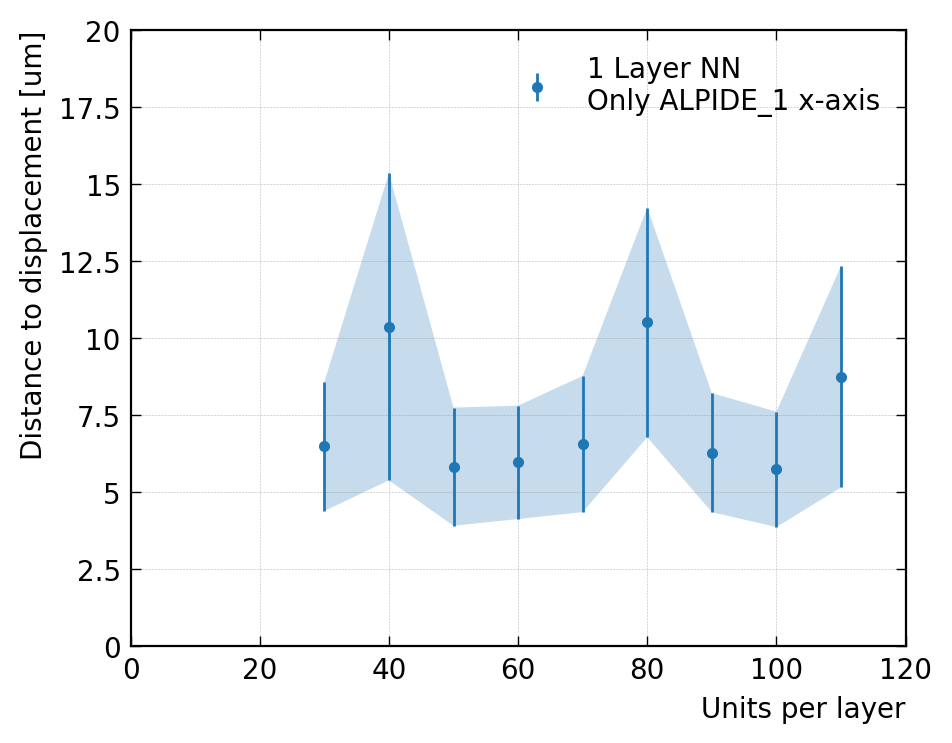

In [200]:

fig = plt.figure(figsize=(5, 4), dpi=200)
xVals = np.array([i for i in range(30,120,10)])
ax = fig.add_subplot(111)
ax.tick_params(axis='both',which='both', direction='in',right=True,top=True, width=0.5)
plt.grid(color='gray', linestyle=':', linewidth=0.2)
ax.set_xlabel("Units per layer", horizontalalignment='right',x=1)
ax.set_ylabel("Distance to displacement [um]", horizontalalignment='right',y=1)
ax.set_xlim(0,120)
ax.set_ylim(0,0.02)
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1000))
ax.yaxis.set_major_formatter(ticks)
ax.errorbar(xVals,meanDists,stdDists/math.sqrt(10),None,'.', label="1 Layer NN\nOnly ALPIDE_1 x-axis", linewidth=1)
ax.fill_between(xVals,meanDists-stdDists/math.sqrt(10),meanDists+stdDists/math.sqrt(10),alpha=0.25,linewidth=1)
l = ax.legend(loc='best', frameon=False)

In [182]:
meanDists/math.sqrt(10)

array([0.00205088, 0.00327945, 0.00184287, 0.00188742, 0.00207562,
       0.00332404, 0.00198728, 0.00181484, 0.00276683])

In [174]:
meanDistsLayers = np.array([])
stdDistsLayers = np.array([])
xVals = np.array([i for i in range(1,6)])
for layers in xVals:
    dists = np.array([])
    for rep in range(10):
        model = trainNetwork(input_data,misalignments,nLayers=layers, units=50)
        disps2test = [{"ALPIDE_0" : [0,0,0],"ALPIDE_1" : [(val-0.5)*2,0,0],"ALPIDE_2" : [0,0,0],"ALPIDE_3" : [0,0,0],"ALPIDE_4" : [0,0,0]} for val in np.random.rand(10)]
        dists = np.append(dists,evalModel(model,disps2test))
    meanDistsLayers = np.append(meanDistsLayers,np.mean(dists))
    stdDistsLayers = np.append(stdDistsLayers,np.std(dists))

Epoch 1/10
1250/1250 [==============================] - 1s 836us/step - loss: 0.1268 - val_loss: 0.0103
Epoch 2/10
1250/1250 [==============================] - 1s 786us/step - loss: 0.0044 - val_loss: 0.0017
Epoch 3/10
1250/1250 [==============================] - 1s 797us/step - loss: 0.0010 - val_loss: 6.3997e-04
Epoch 4/10
1250/1250 [==============================] - 1s 798us/step - loss: 4.4379e-04 - val_loss: 3.1043e-04
Epoch 5/10
1250/1250 [==============================] - 1s 793us/step - loss: 2.2896e-04 - val_loss: 1.7854e-04
Epoch 6/10
1250/1250 [==============================] - 1s 784us/step - loss: 1.4986e-04 - val_loss: 1.1959e-04
Epoch 7/10
1250/1250 [==============================] - 1s 782us/step - loss: 1.1356e-04 - val_loss: 1.0776e-04
Epoch 8/10
1250/1250 [==============================] - 1s 786us/step - loss: 1.1019e-04 - val_loss: 5.8479e-05
Epoch 9/10
1250/1250 [==============================] - 1s 794us/step - loss: 9.4014e-05 - val_loss: 8.7008e-05
Epoch 10/10


32/32 [==============================] - 0s 702us/step
Epoch 1/10
1250/1250 [==============================] - 1s 897us/step - loss: 0.0643 - val_loss: 0.0019
Epoch 2/10
1250/1250 [==============================] - 1s 846us/step - loss: 0.0010 - val_loss: 5.2717e-04
Epoch 3/10
1250/1250 [==============================] - 1s 845us/step - loss: 3.8314e-04 - val_loss: 2.3468e-04
Epoch 4/10
1250/1250 [==============================] - 1s 818us/step - loss: 2.5148e-04 - val_loss: 1.6021e-04
Epoch 5/10
1250/1250 [==============================] - 1s 844us/step - loss: 2.1861e-04 - val_loss: 1.8355e-04
Epoch 6/10
1250/1250 [==============================] - 1s 846us/step - loss: 1.5167e-04 - val_loss: 9.5074e-05
Epoch 7/10
1250/1250 [==============================] - 1s 848us/step - loss: 1.5766e-04 - val_loss: 2.4203e-04
Epoch 8/10
1250/1250 [==============================] - 1s 833us/step - loss: 1.6854e-04 - val_loss: 7.2374e-05
Epoch 9/10
1250/1250 [==============================] - 1s 84

32/32 [==============================] - 0s 740us/step
Epoch 1/10
1250/1250 [==============================] - 2s 949us/step - loss: 0.0144 - val_loss: 6.2443e-04
Epoch 2/10
1250/1250 [==============================] - 1s 887us/step - loss: 3.5338e-04 - val_loss: 2.7364e-04
Epoch 3/10
1250/1250 [==============================] - 1s 890us/step - loss: 2.6383e-04 - val_loss: 1.1959e-04
Epoch 4/10
1250/1250 [==============================] - 1s 889us/step - loss: 1.4130e-04 - val_loss: 7.9028e-05
Epoch 5/10
1250/1250 [==============================] - 1s 877us/step - loss: 1.0685e-04 - val_loss: 4.0764e-04
Epoch 6/10
1250/1250 [==============================] - 1s 904us/step - loss: 9.4381e-05 - val_loss: 4.4264e-05
Epoch 7/10
1250/1250 [==============================] - 1s 892us/step - loss: 1.1430e-04 - val_loss: 3.4950e-05
Epoch 8/10
1250/1250 [==============================] - 1s 876us/step - loss: 8.3572e-05 - val_loss: 1.5253e-04
Epoch 9/10
1250/1250 [==============================]

Epoch 10/10
32/32 [==============================] - 0s 686us/step
Epoch 1/10
1250/1250 [==============================] - 2s 936us/step - loss: 0.0104 - val_loss: 4.3610e-04
Epoch 2/10
1250/1250 [==============================] - 1s 899us/step - loss: 3.5318e-04 - val_loss: 2.1824e-04
Epoch 3/10
1250/1250 [==============================] - 1s 899us/step - loss: 2.6224e-04 - val_loss: 1.5892e-04
Epoch 4/10
1250/1250 [==============================] - 1s 890us/step - loss: 1.6171e-04 - val_loss: 6.3031e-05
Epoch 5/10
1250/1250 [==============================] - 1s 889us/step - loss: 1.0733e-04 - val_loss: 5.5870e-05
Epoch 6/10
1250/1250 [==============================] - 1s 887us/step - loss: 1.4558e-04 - val_loss: 4.5776e-05
Epoch 7/10
1250/1250 [==============================] - 1s 889us/step - loss: 6.1869e-05 - val_loss: 4.8404e-05
Epoch 8/10
1250/1250 [==============================] - 1s 894us/step - loss: 7.5845e-05 - val_loss: 1.9128e-05
Epoch 9/10
1250/1250 [===================

Epoch 9/10
1250/1250 [==============================] - 1s 866us/step - loss: 3.2185e-05 - val_loss: 1.8629e-05
Epoch 10/10
32/32 [==============================] - 0s 655us/step
Epoch 1/10
1250/1250 [==============================] - 2s 992us/step - loss: 0.0061 - val_loss: 2.5027e-04
Epoch 2/10
1250/1250 [==============================] - 1s 935us/step - loss: 2.2765e-04 - val_loss: 2.0893e-04
Epoch 3/10
1250/1250 [==============================] - 1s 924us/step - loss: 1.4933e-04 - val_loss: 1.0136e-04
Epoch 4/10
1250/1250 [==============================] - 1s 936us/step - loss: 9.7867e-05 - val_loss: 6.0942e-05
Epoch 5/10
1250/1250 [==============================] - 1s 927us/step - loss: 1.0428e-04 - val_loss: 7.6646e-05
Epoch 6/10
1250/1250 [==============================] - 1s 923us/step - loss: 7.2721e-05 - val_loss: 3.5285e-05
Epoch 7/10
1250/1250 [==============================] - 1s 936us/step - loss: 6.3539e-05 - val_loss: 1.7762e-05
Epoch 8/10
1250/1250 [===================

Epoch 8/10
1250/1250 [==============================] - 1s 929us/step - loss: 8.2830e-05 - val_loss: 1.1906e-04
Epoch 9/10
1250/1250 [==============================] - 1s 909us/step - loss: 3.4845e-05 - val_loss: 1.3868e-05
Epoch 10/10
32/32 [==============================] - 0s 678us/step
Epoch 1/10
1250/1250 [==============================] - 2s 996us/step - loss: 0.0164 - val_loss: 6.5858e-04
Epoch 2/10
1250/1250 [==============================] - 1s 938us/step - loss: 3.3567e-04 - val_loss: 1.6007e-04
Epoch 3/10
1250/1250 [==============================] - 1s 944us/step - loss: 1.4744e-04 - val_loss: 3.0227e-04
Epoch 4/10
1250/1250 [==============================] - 1s 945us/step - loss: 1.4470e-04 - val_loss: 5.5273e-05
Epoch 5/10
1250/1250 [==============================] - 1s 936us/step - loss: 1.2718e-04 - val_loss: 4.1319e-05
Epoch 6/10
1250/1250 [==============================] - 1s 944us/step - loss: 9.2132e-05 - val_loss: 3.3823e-05
Epoch 7/10
1250/1250 [===================

Epoch 7/10
1250/1250 [==============================] - 1s 950us/step - loss: 8.0594e-05 - val_loss: 3.6109e-04
Epoch 8/10
1250/1250 [==============================] - 1s 947us/step - loss: 7.2556e-05 - val_loss: 2.8432e-05
Epoch 9/10
1250/1250 [==============================] - 1s 941us/step - loss: 8.6143e-05 - val_loss: 1.6266e-05
Epoch 10/10
32/32 [==============================] - 0s 722us/step
Epoch 1/10
1250/1250 [==============================] - 2s 1ms/step - loss: 0.0032 - val_loss: 1.8499e-04
Epoch 2/10
1250/1250 [==============================] - 1s 960us/step - loss: 2.7095e-04 - val_loss: 1.3095e-04
Epoch 3/10
1250/1250 [==============================] - 1s 971us/step - loss: 1.6836e-04 - val_loss: 7.3986e-05
Epoch 4/10
1250/1250 [==============================] - 1s 979us/step - loss: 1.1680e-04 - val_loss: 5.8471e-05
Epoch 5/10
1250/1250 [==============================] - 1s 966us/step - loss: 1.1572e-04 - val_loss: 1.3321e-04
Epoch 6/10
1250/1250 [=====================

Epoch 6/10
1250/1250 [==============================] - 1s 967us/step - loss: 1.2147e-04 - val_loss: 8.2818e-05
Epoch 7/10
1250/1250 [==============================] - 1s 958us/step - loss: 6.4895e-05 - val_loss: 2.7806e-05
Epoch 8/10
1250/1250 [==============================] - 1s 955us/step - loss: 9.7690e-05 - val_loss: 1.7056e-05
Epoch 9/10
1250/1250 [==============================] - 1s 953us/step - loss: 5.9710e-05 - val_loss: 2.1634e-05
Epoch 10/10
32/32 [==============================] - 0s 579us/step
Epoch 1/10
1250/1250 [==============================] - 2s 1ms/step - loss: 0.0057 - val_loss: 2.4552e-04
Epoch 2/10
1250/1250 [==============================] - 1s 971us/step - loss: 3.1372e-04 - val_loss: 1.1501e-04
Epoch 3/10
1250/1250 [==============================] - 1s 963us/step - loss: 1.9842e-04 - val_loss: 8.7529e-05
Epoch 4/10
1250/1250 [==============================] - 1s 971us/step - loss: 1.6183e-04 - val_loss: 1.0910e-04
Epoch 5/10
1250/1250 [=====================

Epoch 5/10
1250/1250 [==============================] - 1s 975us/step - loss: 1.3215e-04 - val_loss: 5.6095e-05
Epoch 6/10
1250/1250 [==============================] - 1s 963us/step - loss: 1.1365e-04 - val_loss: 2.8020e-04
Epoch 7/10
1250/1250 [==============================] - 1s 963us/step - loss: 6.3816e-05 - val_loss: 7.1331e-05
Epoch 8/10
1250/1250 [==============================] - 1s 953us/step - loss: 8.2781e-05 - val_loss: 2.8593e-05
Epoch 9/10
1250/1250 [==============================] - 1s 956us/step - loss: 6.4702e-05 - val_loss: 1.4850e-05
Epoch 10/10
32/32 [==============================] - 0s 641us/step


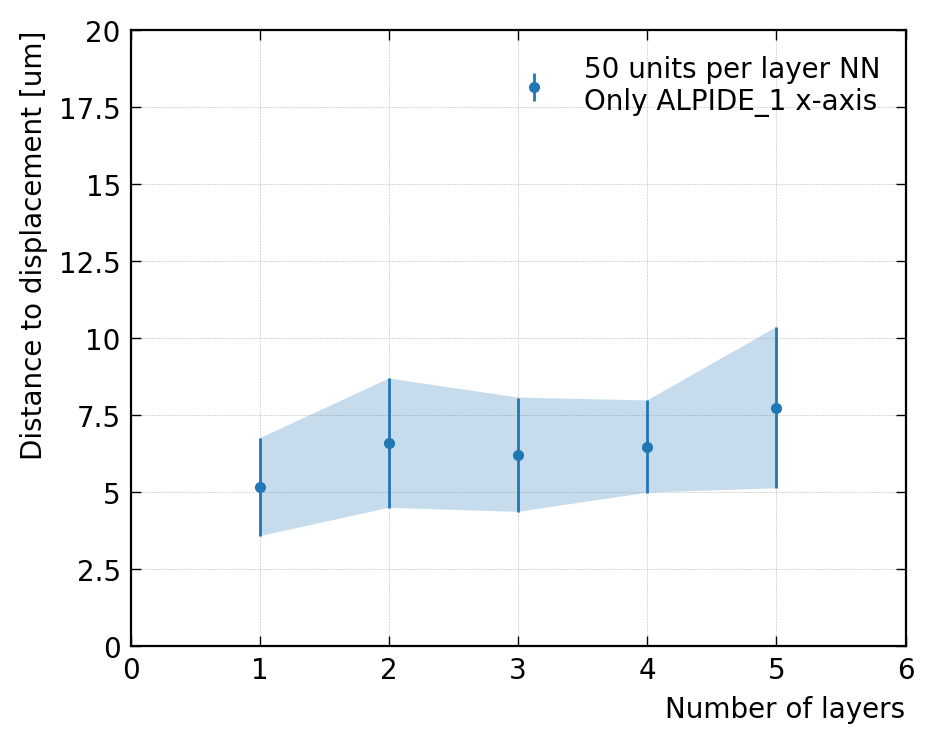

In [202]:
fig = plt.figure(figsize=(5, 4), dpi=200)
ax = fig.add_subplot(111)
xVals = np.array([i for i in range(1,6)])
ax.tick_params(axis='both',which='both', direction='in',right=True,top=True, width=0.5)
plt.grid(color='gray', linestyle=':', linewidth=0.2)
ax.set_xlabel("Number of layers", horizontalalignment='right',x=1)
ax.set_ylabel("Distance to displacement [um]", horizontalalignment='right',y=1)
ax.set_xlim(0,6)
ax.set_ylim(0,0.02)
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1000))
ax.yaxis.set_major_formatter(ticks)
ax.errorbar(xVals,meanDistsLayers,stdDistsLayers/math.sqrt(10),None,'.', label="50 units per layer NN\nOnly ALPIDE_1 x-axis", linewidth=1)
ax.fill_between(xVals,meanDistsLayers-stdDistsLayers/math.sqrt(10),meanDistsLayers+stdDistsLayers/math.sqrt(10),alpha=0.25,linewidth=1)
l = ax.legend(loc='best', frameon=False)

## Demonstrate alignment

In [90]:
%%time
# Create testing data
disps2test=[]
nPoints2test = 10
dispRange = [-1.5,1.5]
for i in range(nPoints2test):
    displacement = {
        "ALPIDE_0" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
        "ALPIDE_1" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
        "ALPIDE_2" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
        "ALPIDE_3" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])],
        "ALPIDE_4" : [random.uniform(dispRange[0], dispRange[1]),random.uniform(dispRange[0], dispRange[1])]
    }
    disps2test.append(displacement)

# Main training loop
nDisps = 500
input_data = np.array([])
misalignments = np.array([])
meanDists = np.array([])
stdDists = np.array([])
medianDists = np.array([])

# Generate data for training
print("Generating displacements ",nDisps)
new_data, new_misalignments = generateData(nDisplacements=nDisps,dispRange=dispRange,nReps=1000,alpides2move=[True,True,True,True,True])
input_data = np.reshape(np.append(input_data,new_data), (-1, 10))
misalignments = np.reshape(np.append(misalignments,new_misalignments), (-1, 10))
# Create model
model = createNetwork(units=50,nLayers=2)
# Train network with new data
model = trainNetwork(model,input_data,misalignments,nEpochs=10,batch=32)
# Evaluate performance of model
dists = np.array([])
dists = evalModel(model,disps2test)
meanDist = np.mean(dists)
medianDist = np.median(dists)
stdDist = np.std(dists)
meanDists = np.append(meanDists,meanDist)
stdDists = np.append(stdDists,stdDist)
medianDists = np.append(medianDists,medianDist)
print(f"Tested {nPoints2test} points and got Mean: {meanDist:.3f} - Median: {medianDist:.3f} - StdDev: {stdDist:.3f}")

Generating displacements  500
Epoch 1/10
12500/12500 [==============================] - 11s 826us/step - loss: 0.2610 - val_loss: 0.1960
Epoch 2/10
12500/12500 [==============================] - 10s 820us/step - loss: 0.1673 - val_loss: 0.1459
Epoch 3/10
12500/12500 [==============================] - 10s 814us/step - loss: 0.1305 - val_loss: 0.1212
Epoch 4/10
12500/12500 [==============================] - 10s 819us/step - loss: 0.1129 - val_loss: 0.1099
Epoch 5/10
12500/12500 [==============================] - 10s 814us/step - loss: 0.1014 - val_loss: 0.0968
Epoch 6/10
12500/12500 [==============================] - 10s 823us/step - loss: 0.0932 - val_loss: 0.0908
Epoch 7/10
12500/12500 [==============================] - 11s 884us/step - loss: 0.0875 - val_loss: 0.0831
Epoch 8/10
12500/12500 [==============================] - 10s 837us/step - loss: 0.0833 - val_loss: 0.0861
Epoch 9/10
12500/12500 [==============================] - 10s 818us/step - loss: 0.0798 - val_loss: 0.0734
Epoch 1

In [91]:
%jsroot on

In [92]:
# Simulate Events
events = []
testData = simulateClusters(10000, returnClusters=True)
for clusters in testData:
    event = Event()
    event.clusters = clusters
    TrackLeft = Track()
    TrackLeft.fromClusters([event.selectDetector(alpide)[0] for alpide in ["ALPIDE_3","ALPIDE_4"]])
    TrackRight = Track()
    TrackRight.fromClusters([event.selectDetector(alpide)[0] for alpide in ["ALPIDE_0","ALPIDE_1","ALPIDE_2"]])
    vertex = Vertex()
    vertex.fromTracks([TrackLeft,TrackRight])
    event.addTrack(TrackLeft)
    event.addTrack(TrackRight)
    event.vertex = vertex
    events.append(event)

hVertexXY = ROOT.TH2F("VertexXY","VertexXY",300,-4,4,300,-4,4)
hVertexXY.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXY.GetYaxis().SetTitle("Vertex Y position [mm]")
hVertexXZ = ROOT.TH2F("VertexXZ","VertexXZ",300,-4,4,300,-22,-14)
hVertexXZ.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXZ.GetYaxis().SetTitle("Vertex Z position [mm]")
hVertexYZ = ROOT.TH2F("VertexYZ","VertexYZ",300,-4,4,300,-22,-14)
hVertexYZ.GetXaxis().SetTitle("Vertex Y position [mm]")
hVertexYZ.GetYaxis().SetTitle("Vertex Z position [mm]")

for event in events:
    hVertexXY.Fill(event.vertex.point[0],event.vertex.point[1])
    hVertexXZ.Fill(event.vertex.point[0],event.vertex.point[2])
    hVertexYZ.Fill(event.vertex.point[1],event.vertex.point[2])
    
canvas = ROOT.TCanvas("","",1200,400)

canvas.Divide(3)
pad1 = canvas.cd(1)
pad1.SetGridx(40)
pad1.SetGridy(2)
hVertexXY.Draw("COLZ")
pad2 = canvas.cd(2)
pad2.SetGridx(2)
pad2.SetGridy(2)
hVertexXZ.Draw("COLZ")
pad3 = canvas.cd(3)
pad3.SetGridx(2)
pad3.SetGridy(2)
hVertexYZ.Draw("COLZ")
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: VertexXY (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexXZ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexYZ (Potential memory leak).


In [93]:
import copy
testDisp = {
    "ALPIDE_0" : [-0.4,0.3],
    "ALPIDE_1" : [0.3,-0.4],
    "ALPIDE_2" : [-0.2,0.2],
    "ALPIDE_3" : [0.3,0.2],
    "ALPIDE_4" : [0.4,-0.4]
}
print(testDisp)
broken_events=[]
events_backup = copy.deepcopy(events)
for event in events_backup:
    for cluster in event.clusters:
        cluster.alignLocal(testDisp.get(cluster.detector))
    broken_events.append(event)
    
for event in broken_events:
    event.tracks = []
    TrackLeft = Track()
    TrackLeft.fromClusters([event.selectDetector(alpide)[0] for alpide in ["ALPIDE_3","ALPIDE_4"]])
    TrackRight = Track()
    TrackRight.fromClusters([event.selectDetector(alpide)[0] for alpide in ["ALPIDE_0","ALPIDE_1","ALPIDE_2"]])
    vertex = Vertex()
    vertex.fromTracks([TrackLeft,TrackRight])
    event.addTrack(TrackLeft)
    event.addTrack(TrackRight)
    event.vertex = vertex

hVertexXY = ROOT.TH2F("VertexXY","VertexXY",300,-4,4,300,-4,4)
hVertexXY.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXY.GetYaxis().SetTitle("Vertex Y position [mm]")
hVertexXZ = ROOT.TH2F("VertexXZ","VertexXZ",300,-4,4,300,-22,-14)
hVertexXZ.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXZ.GetYaxis().SetTitle("Vertex Z position [mm]")
hVertexYZ = ROOT.TH2F("VertexYZ","VertexYZ",300,-4,4,300,-22,-14)
hVertexYZ.GetXaxis().SetTitle("Vertex Y position [mm]")
hVertexYZ.GetYaxis().SetTitle("Vertex Z position [mm]")

for event in broken_events:
    hVertexXY.Fill(event.vertex.point[0],event.vertex.point[1])
    hVertexXZ.Fill(event.vertex.point[0],event.vertex.point[2])
    hVertexYZ.Fill(event.vertex.point[1],event.vertex.point[2])
    
canvas = ROOT.TCanvas("","",1200,400)

canvas.Divide(3)
pad1 = canvas.cd(1)
pad1.SetGridx(40)
pad1.SetGridy(2)
hVertexXY.Draw("COLZ")
pad2 = canvas.cd(2)
pad2.SetGridx(2)
pad2.SetGridy(2)
hVertexXZ.Draw("COLZ")
pad3 = canvas.cd(3)
pad3.SetGridx(2)
pad3.SetGridy(2)
hVertexYZ.Draw("COLZ")
canvas.Draw()

{'ALPIDE_0': [-0.4, 0.3], 'ALPIDE_1': [0.3, -0.4], 'ALPIDE_2': [-0.2, 0.2], 'ALPIDE_3': [0.3, 0.2], 'ALPIDE_4': [0.4, -0.4]}


Warning in <TROOT::Append>: Replacing existing TH1: VertexXY (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexXZ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexYZ (Potential memory leak).


In [94]:
data=[]
for event in broken_events:
    clusters = event.clusters
    data.extend([(cluster.localPos[0],cluster.localPos[1]) for cluster in clusters])
test_data = np.reshape(np.array(data), (-1, 10))
predictions = model.predict(test_data)
predicted_disp = np.mean(predictions,axis=0)
correction = dispArray2Map(predicted_disp*-1)
print(correction)

corrected_events=[]
events_backup = copy.deepcopy(broken_events)
for event in events_backup:
    for cluster in event.clusters:
        cluster.alignLocal(correction.get(cluster.detector))
    corrected_events.append(event)
    
for event in corrected_events:
    event.tracks = []
    TrackLeft = Track()
    TrackLeft.fromClusters([event.selectDetector(alpide)[0] for alpide in ["ALPIDE_3","ALPIDE_4"]])
    TrackRight = Track()
    TrackRight.fromClusters([event.selectDetector(alpide)[0] for alpide in ["ALPIDE_0","ALPIDE_1","ALPIDE_2"]])
    vertex = Vertex()
    vertex.fromTracks([TrackLeft,TrackRight])
    event.addTrack(TrackLeft)
    event.addTrack(TrackRight)
    event.vertex = vertex

hVertexXY = ROOT.TH2F("VertexXY","VertexXY",300,-4,4,300,-4,4)
hVertexXY.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXY.GetYaxis().SetTitle("Vertex Y position [mm]")
hVertexXZ = ROOT.TH2F("VertexXZ","VertexXZ",300,-4,4,300,-22,-14)
hVertexXZ.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXZ.GetYaxis().SetTitle("Vertex Z position [mm]")
hVertexYZ = ROOT.TH2F("VertexYZ","VertexYZ",300,-4,4,300,-22,-14)
hVertexYZ.GetXaxis().SetTitle("Vertex Y position [mm]")
hVertexYZ.GetYaxis().SetTitle("Vertex Z position [mm]")

for event in corrected_events:
    hVertexXY.Fill(event.vertex.point[0],event.vertex.point[1])
    hVertexXZ.Fill(event.vertex.point[0],event.vertex.point[2])
    hVertexYZ.Fill(event.vertex.point[1],event.vertex.point[2])
    
canvas = ROOT.TCanvas("","",1200,400)

canvas.Divide(3)
pad1 = canvas.cd(1)
pad1.SetGridx(40)
pad1.SetGridy(2)
hVertexXY.Draw("COLZ")
pad2 = canvas.cd(2)
pad2.SetGridx(2)
pad2.SetGridy(2)
hVertexXZ.Draw("COLZ")
pad3 = canvas.cd(3)
pad3.SetGridx(2)
pad3.SetGridy(2)
hVertexYZ.Draw("COLZ")
canvas.Draw()

313/313 [==============================] - 0s 528us/step
{'ALPIDE_0': [0.3307152986526489, -0.09484667330980301], 'ALPIDE_1': [-0.42266473174095154, 0.6335632801055908], 'ALPIDE_2': [0.09607791155576706, -0.021787486970424652], 'ALPIDE_3': [-0.19608883559703827, 0.1035919040441513], 'ALPIDE_4': [-0.2940331697463989, 0.6034996509552002]}


Warning in <TROOT::Append>: Replacing existing TH1: VertexXY (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexXZ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexYZ (Potential memory leak).


## Do alignment on data

In [95]:
path = "/home/berki/Software/uits3_krakow22/data/uITS3/chrisPkls/noFlipNeeded/run456114514_221112120005.pkl"
nEvents = -1
selectedEvents = []

for i,event in enumerate(readEvents(path, nEvents=nEvents)):
    if nEvents > 0 and i>0 and i%1e4 == 0: f.value += 1e4
    eventStatus = True
    for alpide in ["ALPIDE_0","ALPIDE_1","ALPIDE_2","ALPIDE_3","ALPIDE_4"]:
        clusters = event.selectDetector(alpide)
        selectedClusters = [cluster for cluster in clusters if (cluster.size > 5 and abs(cluster.localPos[0])<10 and abs(cluster.localPos[1])<5)]
        if len(selectedClusters) != 1:
            eventStatus = False
            break
    if eventStatus : 
        event.clusters = [cluster for cluster in event.clusters if (cluster.size > 5 and abs(cluster.localPos[0])<10 and abs(cluster.localPos[1])<5)]
        selectedEvents.append(event)
        
print("Found events:",len(selectedEvents),", Fraction:",len(selectedEvents)*100/nEvents,"%")

Going to process all events.
Found events: 21247 , Fraction: -2124700.0 %


In [96]:
events=[]
for event in selectedEvents:
    TrackLeft = Track()
    TrackLeft.fromClusters([event.selectDetector(alpide)[0] for alpide in ["ALPIDE_3","ALPIDE_4"]])
    TrackRight = Track()
    TrackRight.fromClusters([event.selectDetector(alpide)[0] for alpide in ["ALPIDE_0","ALPIDE_1","ALPIDE_2"]])
    vertex = Vertex()
    vertex.fromTracks([TrackLeft,TrackRight])
    event.addTrack(TrackLeft)
    event.addTrack(TrackRight)
    event.vertex = vertex
    events.append(event)

In [109]:
hVertexXY = ROOT.TH2F("VertexXY","VertexXY",300,-4,4,300,-4,4)
hVertexXY.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXY.GetYaxis().SetTitle("Vertex Y position [mm]")
hVertexXZ = ROOT.TH2F("VertexXZ","VertexXZ",300,-4,4,300,-22,-14)
hVertexXZ.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXZ.GetYaxis().SetTitle("Vertex Z position [mm]")
hVertexYZ = ROOT.TH2F("VertexYZ","VertexYZ",300,-4,4,300,-22,-14)
hVertexYZ.GetXaxis().SetTitle("Vertex Y position [mm]")
hVertexYZ.GetYaxis().SetTitle("Vertex Z position [mm]")

for event in events:
    hVertexXY.Fill(event.vertex.point[0],event.vertex.point[1])
    hVertexXZ.Fill(event.vertex.point[0],event.vertex.point[2])
    hVertexYZ.Fill(event.vertex.point[1],event.vertex.point[2])
    
canvas = ROOT.TCanvas("","",1200,400)

canvas.Divide(3)
pad1 = canvas.cd(1)
pad1.SetGridx(40)
pad1.SetGridy(2)
hVertexXY.Draw("COLZ")
pad2 = canvas.cd(2)
pad2.SetGridx(2)
pad2.SetGridy(2)
hVertexXZ.Draw("COLZ")
pad3 = canvas.cd(3)
pad3.SetGridx(2)
pad3.SetGridy(2)
hVertexYZ.Draw("COLZ")
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: VertexXY (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexXZ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexYZ (Potential memory leak).


In [110]:
%jsroot on
hOpeningAngle = ROOT.TH1F("Opening_Angle","Opening Angle",300,70,100)
hOpeningAngle.GetXaxis().SetTitle("Opening angle between two tracks [°]")
hOpeningAngle.GetYaxis().SetTitle("Count")
hRMS = ROOT.TH1F("RMS cluster","Track fit goodness",22*5,-0.1,2.1)
hRMS.GetXaxis().SetTitle("RMS (cluster distance in track) [mm]")
hRMS.GetYaxis().SetTitle("Count")
hDCA = ROOT.TH1F("DCA","DCA between tracks",500,-0.1,5.1)
hDCA.GetXaxis().SetTitle("DCA between the tracks from 2 arms [mm]")
hDCA.GetYaxis().SetTitle("Count")

for event in events:
    hOpeningAngle.Fill(event.vertex.openingAngle*360/(2*math.pi))
    hDCA.Fill(event.vertex.dca)
    for track in event.tracks:
        if track.nClusters == 3: hRMS.Fill(track.rms)
    
canvas = ROOT.TCanvas("","",1200,400)
canvas.Divide(3)
canvas.cd(1)
ROOT.gPad.SetGridx(2)
hOpeningAngle.Draw()
canvas.cd(2)
ROOT.gPad.SetGridx(2)
hDCA.Draw()
canvas.cd(3)
ROOT.gPad.SetGridx(2)
hRMS.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: Opening_Angle (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: RMS cluster (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DCA (Potential memory leak).


In [99]:
data=[]
for event in events:
    clusters = event.clusters
    data.extend([(cluster.localPos[0],cluster.localPos[1]) for cluster in clusters])
test_data = np.reshape(np.array(data), (-1, 10))
predictions = model.predict(test_data)
predicted_disp = np.mean(predictions,axis=0)
correction = dispArray2Map(predicted_disp*-1)
print(correction)

664/664 [==============================] - 0s 702us/step
{'ALPIDE_0': [0.42696571350097656, -0.2530856430530548], 'ALPIDE_1': [1.4094219207763672, -0.17744961380958557], 'ALPIDE_2': [0.7577999234199524, -0.1775711476802826], 'ALPIDE_3': [0.17879310250282288, -0.6636990308761597], 'ALPIDE_4': [-0.006437917239964008, -0.4330303966999054]}


In [114]:
corrected_events=[]
events_backup = copy.deepcopy(events)
for event in events_backup:
    for cluster in event.clusters:
        cluster.alignLocal(correction.get(cluster.detector))
    corrected_events.append(event)
    
for event in corrected_events:
    event.tracks = []
    TrackLeft = Track()
    TrackLeft.fromClusters([event.selectDetector(alpide)[0] for alpide in ["ALPIDE_3","ALPIDE_4"]])
    TrackRight = Track()
    TrackRight.fromClusters([event.selectDetector(alpide)[0] for alpide in ["ALPIDE_0","ALPIDE_1","ALPIDE_2"]])
    vertex = Vertex()
    vertex.fromTracks([TrackLeft,TrackRight])
    event.addTrack(TrackLeft)
    event.addTrack(TrackRight)
    event.vertex = vertex

hVertexXYCorrected = ROOT.TH2F("VertexXY","VertexXY Corrected",300,-4,4,300,-4,4)
hVertexXYCorrected.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXYCorrected.GetYaxis().SetTitle("Vertex Y position [mm]")
hVertexXZCorrected = ROOT.TH2F("VertexXZ","VertexXZ Corrected",300,-4,4,300,-22,-14)
hVertexXZCorrected.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXZCorrected.GetYaxis().SetTitle("Vertex Z position [mm]")
hVertexYZCorrected = ROOT.TH2F("VertexYZ","VertexYZ Corrected",300,-4,4,300,-22,-14)
hVertexYZCorrected.GetXaxis().SetTitle("Vertex Y position [mm]")
hVertexYZCorrected.GetYaxis().SetTitle("Vertex Z position [mm]")

for event in corrected_events:
    hVertexXYCorrected.Fill(event.vertex.point[0],event.vertex.point[1])
    hVertexXZCorrected.Fill(event.vertex.point[0],event.vertex.point[2])
    hVertexYZCorrected.Fill(event.vertex.point[1],event.vertex.point[2])
    
canvas = ROOT.TCanvas("","",1200,400)

canvas.Divide(3)
pad1 = canvas.cd(1)
pad1.SetGridx(40)
pad1.SetGridy(2)
hVertexXYCorrected.Draw("COLZ")
pad2 = canvas.cd(2)
pad2.SetGridx(2)
pad2.SetGridy(2)
hVertexXZCorrected.Draw("COLZ")
pad3 = canvas.cd(3)
pad3.SetGridx(2)
pad3.SetGridy(2)
hVertexYZCorrected.Draw("COLZ")
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: VertexXY (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexXZ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexYZ (Potential memory leak).


In [105]:
%jsroot on
hOpeningAngleCorrected = ROOT.TH1F("Opening_Angle","Opening Angle",300,70,100)
hOpeningAngleCorrected.GetXaxis().SetTitle("Opening angle between two tracks [°]")
hOpeningAngleCorrected.GetYaxis().SetTitle("Count")
hRMSCorrected = ROOT.TH1F("RMS cluster","Track fit goodness",22*5,-0.1,2.1)
hRMSCorrected.GetXaxis().SetTitle("RMS (cluster distance in track) [mm]")
hRMSCorrected.GetYaxis().SetTitle("Count")
hDCACorrected = ROOT.TH1F("DCA","DCA between tracks",500,-0.1,5.1)
hDCACorrected.GetXaxis().SetTitle("DCA between the tracks from 2 arms [mm]")
hDCACorrected.GetYaxis().SetTitle("Count")

for event in corrected_events:
    hOpeningAngleCorrected.Fill(event.vertex.openingAngle*360/(2*math.pi))
    hDCACorrected.Fill(event.vertex.dca)
    for track in event.tracks:
        if track.nClusters == 3: hRMSCorrected.Fill(track.rms)
    
canvas = ROOT.TCanvas("","",1200,400)
canvas.Divide(3)
canvas.cd(1)
ROOT.gPad.SetGridx(2)
hOpeningAngleCorrected.Draw()
canvas.cd(2)
ROOT.gPad.SetGridx(2)
hDCACorrected.Draw()
canvas.cd(3)
ROOT.gPad.SetGridx(2)
hRMSCorrected.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: Opening_Angle (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: RMS cluster (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DCA (Potential memory leak).


In [116]:
canvas = ROOT.TCanvas("","",1200,1000)

canvas.Divide(3,3)
canvas.cd(1)
ROOT.gPad.SetGridx(40)
ROOT.gPad.SetGridy(2)
hVertexXY.Draw("COLZ SAME")
canvas.cd(2)
ROOT.gPad.SetGridx(2)
ROOT.gPad.SetGridy(2)
hVertexXZ.Draw("COLZ SAME")
canvas.cd(3)
ROOT.gPad.SetGridx(2)
ROOT.gPad.SetGridy(2)
hVertexYZ.Draw("COLZ SAME")
canvas.cd(4)
ROOT.gPad.SetGridx(40)
ROOT.gPad.SetGridy(2)
hVertexXYCorrected.Draw("COLZ SAME")
canvas.cd(5)
ROOT.gPad.SetGridx(2)
ROOT.gPad.SetGridy(2)
hVertexXZCorrected.Draw("COLZ SAME")
canvas.cd(6)
ROOT.gPad.SetGridx(2)
ROOT.gPad.SetGridy(2)
hVertexYZCorrected.Draw("COLZ SAME")
canvas.cd(7)
ROOT.gPad.SetGridx(2)
hOpeningAngle.Draw("SAME PLC PMC")
hOpeningAngleCorrected.Draw("SAME PLC PMC")
canvas.cd(8)
ROOT.gPad.SetGridx(2)
hDCA.Draw("SAME PLC PMC")
hDCACorrected.Draw("SAME PLC PMC")
canvas.cd(9)
ROOT.gPad.SetGridx(2)
hRMS.Draw("SAME PLC PMC")
hRMSCorrected.Draw("SAME PLC PMC")
canvas.Draw()
